In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [78]:
#https://medium.datadriveninvestor.com/time-series-prediction-using-sarimax-a6604f258c56
#https://finance.yahoo.com/quote/AAPL/history?period1=1222837200&period2=1569906000&interval=1d&filter=history&frequency=1d
#https://finance.yahoo.com/quote/AAPL/history/?guccounter=1&guce_referrer=aHR0cHM6Ly93d3cuZ29vZ2xlLmNvbS8&guce_referrer_sig=AQAAACzup2zx_CD-w_bppEbO46ENw5kvClFQR486XpiaHw0IfnUOo_Eu-FaKzGTbemdXCtCJfzvcv5N6_Op33sfNKWDm5WAs4LBl1usqyCvrRqzu7sdnVm09f1cufDB4RfS8qqXaAkybnbcQaWyBvzoDzzaEBVIKVYQrh0X_FmnqjdBd
dataset= pd.read_csv(r'C:\Users\91783\Downloads\aapl.csv')

In [79]:
dataset.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,10-1-08,3.997143,4.012857,3.835357,3.897143,3.327504,1296484000
1,10-2-08,3.857500,3.885357,3.571429,3.575000,3.052449,1609364400


In [37]:
dataset['Mean'] = (dataset['Low'] + dataset['High'])/2
dataset.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume,Mean
0,10-1-08,3.997143,4.012857,3.835357,3.897143,3.327504,1296484000,3.924107
1,10-2-08,3.857500,3.885357,3.571429,3.575000,3.052449,1609364400,3.728393


In [38]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2767 entries, 0 to 2766
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2767 non-null   object 
 1   Open       2767 non-null   float64
 2   High       2767 non-null   float64
 3   Low        2767 non-null   float64
 4   Close      2767 non-null   float64
 5   Adj Close  2767 non-null   float64
 6   Volume     2767 non-null   int64  
 7   Mean       2767 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 173.1+ KB


In [39]:
steps=-1
dataset_for_prediction= dataset.copy()
dataset_for_prediction['Actual']=dataset_for_prediction['Mean'].shift(steps)
dataset_for_prediction.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume,Mean,Actual
0,10-1-08,3.997143,4.012857,3.835357,3.897143,3.327504,1296484000,3.924107,3.728393
1,10-2-08,3.857500,3.885357,3.571429,3.575000,3.052449,1609364400,3.728393,3.591964
2,10-3-08,3.714286,3.803571,3.380357,3.466786,2.960052,2294398400,3.591964,3.327143


In [40]:
dataset_for_prediction=dataset_for_prediction.dropna()

In [41]:
dataset_for_prediction['Date'] =pd.to_datetime(dataset_for_prediction['Date'])
dataset_for_prediction.index= dataset_for_prediction['Date']

Text(0.5, 1.0, ' Apple Opening Stock Value')

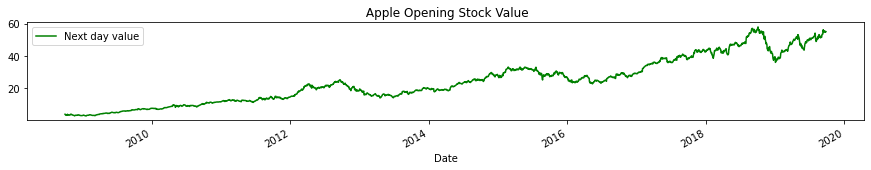

In [42]:
dataset_for_prediction['Mean'].plot(color='green', figsize=(15,2))
plt.legend(['Next day value', 'Mean'])
plt.title(" Apple Opening Stock Value")

Text(0.5, 1.0, 'Apple Stock Volume')

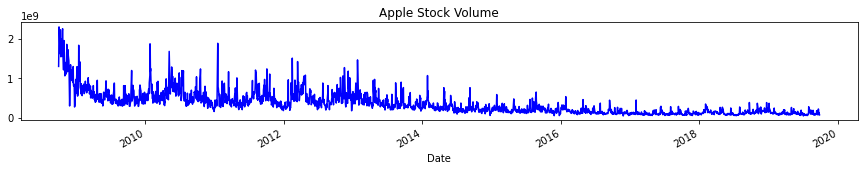

In [43]:
dataset_for_prediction['Volume'].plot(color='blue', figsize=(15,2))
plt.title("Apple Stock Volume")

In [44]:
from sklearn.preprocessing import MinMaxScaler
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(dataset_for_prediction[['Low', 'High','Open', 'Close', 'Volume', 'Adj Close', 'Mean']])
scaled_input =pd.DataFrame(scaled_input)
X= scaled_input

In [45]:
sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(dataset_for_prediction[['Actual']])
scaler_output =pd.DataFrame(scaler_output)
y=scaler_output

In [46]:
X.rename(columns={0:'Low', 1:'High', 2:'Open', 3:'Close', 4:'Volume', 5:'Adj Close', 6:'Mean'}, inplace=True)
X.head(2)

,Low,High,Open,Close,Volume,Adj Close,Mean
0,0.019075,0.019558,0.021177,0.019996,0.556275,0.01762,0.019318
1,0.014246,0.017258,0.018632,0.014163,0.695398,0.01248,0.015763


In [47]:
y.rename(columns={0:'Stock Price next day'}, inplace= True)
y.index=dataset_for_prediction.index
y.head(2)

,Stock Price next day
Date,
2008-10-01,0.015763
2008-10-02,0.013284


In [48]:
train_size=int(len(dataset) *0.7)
test_size = int(len(dataset))-train_size
train_X, train_y = X[:train_size].dropna(), y[:train_size].dropna()
test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()

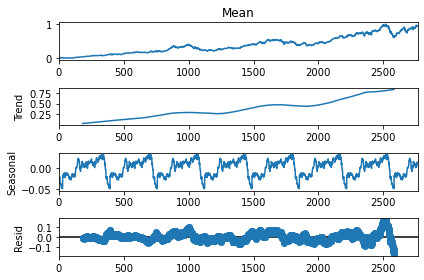

In [49]:
import statsmodels.api as sm
seas_d=sm.tsa.seasonal_decompose(X['Mean'],model='add',period=365);
fig=seas_d.plot()
fig.set_figheight(4)
plt.show()

In [51]:
from statsmodels.tsa.stattools import adfuller
def test_adf(series, title=''):
    dfout={}
    dftest=sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
    if dftest[1]<=0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for  Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)

In [53]:
y_test=y['Stock Price next day'][:train_size].dropna()
test_adf(y_test, " Stock Price")

Strong evidence for  Null Hypothesis
Accept Null Hypothesis - Data is not Stationary
Data is NOT Stationary for  Stock Price


In [54]:
test_adf(y_test.diff(), "Stock Price")

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is Stationary
Data is Stationary Stock Price


C:\Users\91783\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


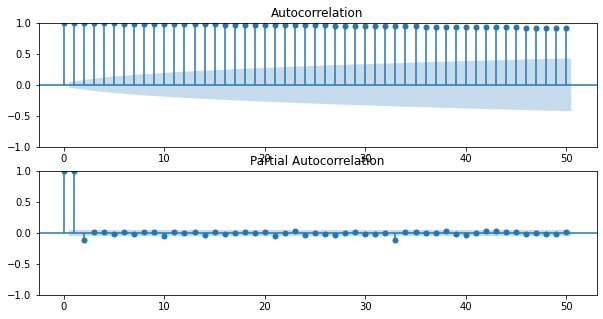

In [55]:
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(y_test, lags=50, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(y_test, lags=50, ax=ax[1])
plt.show()

In [57]:
from pmdarima.arima import auto_arima
step_wise=auto_arima(train_y, 
 exogenous= train_X,
 start_p=1, start_q=1, 
 max_p=7, max_q=7, 
 d=1, max_d=7,
 trace=True, 
 error_action='ignore', 
 suppress_warnings=True, 
 stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-15575.832, Time=2.85 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-15549.019, Time=0.82 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-15593.611, Time=3.98 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-15562.790, Time=1.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-15548.661, Time=1.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-15594.725, Time=2.99 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-15591.995, Time=3.34 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-15558.886, Time=1.70 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-15557.039, Time=2.28 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-15612.064, Time=2.68 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-15594.633, Time=2.51 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-15591.390, Time=2.96 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-15605.762, Time=3.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-15574.758, Time=2.42 sec
 ARIM

In [62]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1936
Model:               SARIMAX(5, 1, 2)   Log Likelihood                7846.843
Date:                Sat, 27 Aug 2022   AIC                         -15663.685
Time:                        14:48:45   BIC                         -15580.167
Sample:                             0   HQIC                        -15632.968
                               - 1936                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Low            0.0333      0.029      1.134      0.257      -0.024       0.091
High          -0.0121      0.029     -0.411      0.681      -0.070       0.046
Open          -0.0781      0.033     -2.388      0.017      -0.142      -0.014
Close          0.8645      0.233      3.714      0.000       0.408       1.321
Volume         0.0017      0.001      1.133      0.257      -0.001       0.005
Adj Close     -0.0132      0.244     -0.054      0.957      -0.492       0.466
Mean           0.0105      0.022      0.465      0.642      -0.034       0.055
ar.L1         -0.4041      0.463     -0.873      0.383      -1.312       0.503
ar.L2         -0.2046      0.089     -2.298      0.022      -0.379      -0.030
ar.L3         -0.1338      0.073     -1.829      0.067      -0.277       0.010
ar.L4         -0.0808      0.049     -1.651      0.099      -0.177       0.015
ar.L5         -0.0575      0.029     -1.975      0.048      -0.115      -0.000
ma.L1         -0.3264      0.462     -0.707      0.480      -1.232       0.579
ma.L2         -0.1433      0.335     -0.427      0.669      -0.801       0.514
sigma2      1.755e-05   2.19e-07     79.995      0.000    1.71e-05     1.8e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):             17375.08
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               7.39   Skew:                            -0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.19e+17. Standard errors may be unstable.
"""

In [64]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model=sm.tsa.statespace.SARIMAX(train_y,order=(0, 1, 1),seasonal_order=(0,1,1,12))
#model= SARIMAX(train_y, exog=train_X,order=(0,1,1), enforce_invertibility=False, enforce_stationarity=False)

C:\Users\91783\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\91783\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [65]:
results= model.fit()

In [66]:
predictions= results.predict(start =train_size, end=train_size+test_size+(steps)-1,exog=test_X)

C:\Users\91783\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [67]:
forecast_1= results.forecast(steps=test_size-1, exog=test_X)

C:\Users\91783\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [68]:
act= pd.DataFrame(scaler_output.iloc[train_size:, 0])

In [72]:
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X.index
predictions['Actual'] = act['Stock Price next day']
predictions.rename(columns={0:'Pred'}, inplace=True)

In [75]:
act

,Stock Price next day
Date,
2016-06-10,0.393616
2016-06-13,0.391368
2016-06-14,0.391844
2016-06-15,0.388166
2016-06-16,0.383919
...,...
2019-09-20,0.941503
2019-09-23,0.946476
2019-09-24,0.944114


In [76]:
predictions

,predicted_mean,Actual
1936,0.397241,NaN
1937,0.396827,NaN
1938,0.397199,NaN
1939,0.396392,NaN
1940,0.391162,NaN
...,...,...
2761,0.190601,NaN
2762,0.191737,NaN
2763,0.192615,NaN
2764,0.192928,NaN
